<a href="https://colab.research.google.com/github/SandervandenBergh/predictive_ana/blob/main/Amount_of_tickets_for_support_groups_(predictive_analytics).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [ ]:
import numpy as np
import pandas as pd
import pandas.testing as tm
import matplotlib.pyplot as plt
import matplotlib
import re
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error, confusion_matrix, plot_confusion_matrix
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

from scipy.optimize import minimize
from scipy import stats
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from fbprophet import Prophet

from tqdm import tqdm_notebook

from itertools import product

from datetime import date
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

import logging
import random
import warnings
import time

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Import Data

In [ ]:
warnings.filterwarnings('ignore')
%matplotlib inline

DATAPATH = '/content/incident_ticket data goed.xlsx'
data = pd.read_excel(DATAPATH)

data.head(10)

,IncidentNumber,ServiceType,Servicestypes,TicketDescription,Created Date,Closed Data,LastModifiedTime,Priority,Impact,SupportGroupName,Company,ResolutionDescription,estimated hours,Reported,Date
0,1234567,Incidents,Incident,investigate authorization issue in PRD,3/5/2019 3:00,2020-01-01 00:46:51,2019-04-05 11:59:59,P1,4,MMEAI,ACCENTURE - INTERNAL ORGANIZATIONS,Tableau: ES Contact Center Metrics dashboard u...,3,2019-05-03 00:00:00,03:00:00
1,1234569,Incidents,RequestS,Not able to view anything on Cransoft,8/19/2019 3:00,2020-01-03 05:09:00,2019-09-19 11:59:59,P1,4,MMEAI,ACCENTURE - INTERNAL ORGANIZATIONS,345407 Beeline PR_US PPD_August 2016 - Data do...,20,8/19/2019,03:00:00
2,1234571,Incidents,Incident,Unable to login to one of the sharepoint site:...,6/7/2019 3:00,2020-01-03 05:06:19,2020-03-06 10:59:59,P1,2,MME123,ACCENTURE - INTERNAL ORGANIZATIONS,Can you please check why the accounts for Iryn...,13,2019-07-06 00:00:00,03:00:00
3,1234573,Incidents,Incident,Unable to activate Tableau software,4/29/2019 3:00,2020-01-01 01:23:16,2019-04-30 11:59:59,P1,3,parent123,ACCENTURE - INTERNAL ORGANIZATIONS,Access to PDHQ,10,4/29/2019,03:00:00
4,1234575,Incidents,Incident,eSubMIT-IVAL: Getting Validation Error 1153 (M...,9/17/2019 3:00,2020-01-02 12:55:40,2019-10-18 11:59:59,P1,5,MMEAI,ACCENTURE - INTERNAL ORGANIZATIONS,Product returned from Puerto Rico Issue,20,9/17/2019,03:00:00
5,1234577,Incidents,RequestS,Sharepoint - user is unable to edit files but ...,5/27/2019 3:00,2020-01-02 07:14:23,2019-05-28 11:59:59,P1,3,parent123,ACCENTURE - INTERNAL ORGANIZATIONS,"In Benchtop Computer Request workflow, additio...",12,5/27/2019,03:00:00
6,1234579,Incidents,RequestS,CLINSIGHT: one issue of site 0004 about patien...,6/16/2019 3:00,2020-01-01 03:39:10,2019-07-17 11:59:59,P1,1,MMEAI,ACCENTURE - INTERNAL ORGANIZATIONS,User was unable to submit report via ClinSight...,10,6/16/2019,03:00:00
7,1234581,Incidents,RequestS,Junk Email-please block junk email sent from z...,11/21/2019 3:00,2020-01-01 01:46:51,2020-08-20 11:59:59,P1,2,MME123,ACCENTURE - INTERNAL ORGANIZATIONS,Folders are empty in CARA - PRISM,15,11/21/2019,03:00:00
8,1234583,Incidents,RequestS,18312938 sap_rpm_yy_zffiod02_ctmsintfndpoc_zfp...,5/3/2019 3:00,2020-01-01 09:23:56,2019-05-04 11:59:59,P1,3,parent123,ACCENTURE - INTERNAL ORGANIZATIONS,eDM/OC: Frozen behavior. unable to change stud...,20,2019-03-05 00:00:00,03:00:00
9,1234585,Incidents,Incident,Trackwise &gt;.Unable to access&gt;&gt;just spins,11/11/2019 3:00,2020-01-01 10:37:59,2020-08-10 11:59:59,P1,1,MME123,ACCENTURE - INTERNAL ORGANIZATIONS,ENARRATOR: Error message Web service request i...,20,2019-11-11 00:00:00,03:00:00


## Mount google drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#data = data[data.TICKER != 'Incident']
#data = data[data.TYPE != 'SR']
# this can be used when we have different ticket type of data


# Data Preparation / Pre- Processing



### Column selection

In [ ]:
# Extract only relevant columns
def get_relevant_data(df, service_type_, support_group_name_):
  data_servicestype = df[df['Servicestypes'] == service_type_]
  data_servicestype = data_servicestype[data_servicestype['SupportGroupName'] == support_group_name_]
  drop_cols = ['ServiceType', 'TicketDescription', 'Company','ResolutionDescription', 'estimated hours ', 'Reported', 'Date', 'Closed Data','LastModifiedTime', 'Priority', 'Impact']
  data_columns_chosen= data_servicestype.drop(drop_cols, axis=1, inplace=False)

  # Change created date to datetime format and only consider the date (removing time)
  data_columns_chosen['Created Date'] = pd.to_datetime(data_columns_chosen['Created Date'])
  data_columns_chosen['Created Date'] = data_columns_chosen['Created Date'].dt.date

  return data_columns_chosen

### Artificial data ingestion

In [ ]:
def add_artificial_data(original_df, years,rand_state):
  # Copy df and add x years to the created date (existing dates are duplicated for x years )
  artificial_data = original_df.copy()
  artificial_data['Created Date'] = artificial_data['Created Date'].map(lambda x: x.replace(year = x.year + years))

  # random sampling as added variance to the artificial data
  variance = artificial_data.sample(frac=0.50, random_state=rand_state) #random_state=1
  artificial_data = pd.concat([artificial_data, variance])

  return pd.concat([original_df, artificial_data])

### Aggregate to get counts

In [ ]:
def aggregate_counts(df):
  # Group by dates
  data_count = df.groupby(['Created Date']).count()
  data_count.rename(columns = {'IncidentNumber':'TicketCount'}, inplace = True)

  # Change index to datetime and sort on date
  data_count.index = pd.to_datetime(data_count.index)
  data_count = data_count.sort_index()
  #data_count = data_count[data_count.index > datetime(2013,1,1)]

  # Fill missing days with 0 ticket counts
  idx_fill = pd.date_range(min(data_count.index), max(data_count.index))
  data_count = data_count.reindex(idx_fill, fill_value=0) # Grouped by day

  # Group ticket count by month
  data_month = data_count.groupby(pd.Grouper(freq='M')).sum()
  return data_month

In [ ]:
def plot_inflow(data_month, title_):
  fig, ax = plt.subplots(figsize=(10, 4))

  plt.plot(data_month.TicketCount)
  ax.set_xticks(data_month.index)
  plt.title(title_ + ' - Inflow tickets - Month')
  plt.ylabel('Ticket Count')
  plt.xlabel('Date')
  plt.xticks(rotation=90)

# Modelling

To model a time-series, the data must be stationary, i.e., constant mean and variance. 

Here the Dickey-Fuller test is applied to see if the stationary.

## Stationary

The Dickey-Fuller test shows that the p value is larger than zero. This means that the data is NOT stationary.

Therefore, to get rid of the high autocorrelation and to make the process stationary, let’s take the difference. We simply subtract the time series from itself with a lag of x month, and we get:

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
# Function to find how many differences are needed to get stationarity
def find_diff_stationary(series):
  p_min = 10
  lag = 0
  for i in range(1,30):
    data_diff = series - series.shift(i)
    result = adfuller(data_diff[i:])
    if(result[1] < p_min):
      p_min = result[1]
      lag = i
      print('p value:',p_min,',at diff of:', i)
    if p_min < 0.0001:
       return lag, p_min
  return lag, p_min

A stationary process is found after subtracting the time series from itself with a lag of 1 months.

Use the autocorrelation (ACF) and the partial autocorrelation (PACF) to determine the order of auto regression (AR) and the order of moving average (MA).

Rule of thumb for order determination through ACF and PACF.
The largest significant lag equals the order.
- Find the MA order using the ACF.
 - 1
- Find the AR order using the PACF.
 - 1


 Instead, we will optimize the SARIMA algorithm through trial-and-error.

## Seasonal autoregressive integraded moving average model (SARIMA)

In [ ]:
# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(train_data, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

### Testing


In [ ]:
def residual_plot(residuals):
  plt.figure(figsize=(10,4))
  plt.plot(residuals)
  plt.axhline(0, linestyle='--', color='k')
  plt.title('Residuals from SARIMA Model', fontsize=20)
  plt.ylabel('Error', fontsize=16)
  plt.xticks(rotation=90)

In [ ]:
def test_plot(data_month, predictions, title_, SMAPE):
  plt.figure(figsize=(10,4))

  plt.plot(data_month.TicketCount)
  plt.plot(predictions)

  plt.legend(('Data', 'Predictions'), fontsize=16)
  plt.title(title_+' - Ticket count - SMAPE: ' + str(SMAPE), fontsize=20)
  plt.ylabel('Ticket count', fontsize=16)

### Error measures - SARIMA

In [ ]:
# Define the function to return the SMAPE value
def calculate_smape(actual, predicted) -> float:
    actual = np.array(actual)
    pedicted = np.array(predicted)
    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )

In [ ]:
def error_measures(test_data, predictions, residuals):
  SMAPE = calculate_smape(test_data, predictions)
  MAE = round(np.mean(abs(residuals-test_data)),4)
  RMSE = np.sqrt(np.mean(residuals**2))
  print('Symmetric Mean Absolute Percentage Error:', SMAPE,'%') 
  print('Mean Absolute Error:', MAE)
  print('Root Mean Squared Error:', RMSE)
  return SMAPE, MAE, RMSE

## Forecasting

In [ ]:
def forecast_data(df, p, d, q, P, D, Q, s):
  final_data_date = max(df.index)
  forecast_dates = [final_data_date + timedelta(days=30*idx) for idx in range(3+1)]

  forecast_predictions = data_month.TicketCount.copy()

  start_time = time.time()
  for train_end in forecast_dates:
      train_data = forecast_predictions[:train_end-timedelta(days=30)]
      model = sm.tsa.statespace.SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
      model_fit = model.fit()

      pred = model_fit.forecast()
      forecast_predictions[train_end] = int(pred.values)
  end_time = time.time()
  print('Forecasting time:',end_time-start_time,'s')

  return forecast_predictions, forecast_dates

In [ ]:
def plot_forecast(data_month, forecast_predictions,forecast_dates,title_):
  plt.figure(figsize=(10,4))
  plt.plot(data_month.TicketCount)
  plt.plot(forecast_predictions[forecast_dates])

  plt.legend(('Data', 'Predictions'), fontsize=16)
  plt.title(title_+' - Ticket count', fontsize=20)
  plt.ylabel('Ticket count', fontsize=16)

# Main


In [ ]:
main = False
if main:
  ## Data preparation
  start_time = time.time()
  results_dict = {}
  sarima_optimized_dict = {}
  pre_param = {'MMEAI':(0,1,2,0),
  'MME123':(0,0,0,0),
  'parent123':(0,3,1,0),
  'InitSup':(0,1,2,0),
  'DFCSup':(1,0,0,0),
  'RTCSup':(1,0,2,0),
  'MME5':(1,1,1,0),
  'Assign102':(0,0,0,0),
  'Assign21':(0,1,2,0),
  'Assign27':(4,2,2,0)
  }
  use_pre_param = True # !!!!!!!! set to false to optimize

  # Data selection
  selected_service_type = 'Incident'
  # selected_support_group_name = 'parent123'

  for i in data.SupportGroupName.unique():
    print('Forecasting support group:', i)
    if ((data[data.SupportGroupName == i]).empty):
      break;

    # Column selection
    data_columns_chosen = get_relevant_data(data, selected_service_type, i)

    # Synthetic data ingestion
    rand_state=1
    data_columns_chosen = add_artificial_data(data_columns_chosen, 1, rand_state)
    data_columns_chosen = add_artificial_data(data_columns_chosen, 2, rand_state)

    # Aggregate to get counts
    data_month = aggregate_counts(data_columns_chosen)
    plot_inflow(data_month, i)

    ## Modeling 
    # Find lag for stationarity
    lag, p_min = find_diff_stationary(data_month.TicketCount)

    # 3 months as test data
    train_end = datetime(2022,9,30) #train_end = datetime(2019,10,1)
    test_end = datetime(2022,12,31) #test_end = datetime(2019,12,31)
    train_data = data_month.TicketCount[:train_end]
    test_data = data_month.TicketCount[train_end + timedelta(days=31):test_end]

    # Optimize SARIMA - Set initial values and some bounds
    ps = range(0, 5)  # maximum lag
    d = lag #1        # number of differences required to make the series stationary
    qs = range(0, 5)  # biggest lag after which other lags are not significant
    Ps = range(0, 5)  # seasonal maximum lag
    D = lag #1        # seasonal number of differences required to make the series stationary
    Qs = range(0, 5)  # seasonal biggest lag after which other lags are not significant
    s = 12             # season's length in months

    # Create a list with all possible combinations of parameters
    parameters = product(ps, qs, Ps, Qs)
    parameters_list = list(parameters)

    if not use_pre_param:
      # Optimize
      result_table = optimize_SARIMA(parameters_list, d, D, s)

      #Set parameters that give the lowest AIC (Akaike Information Criteria)
      p, q, P, Q = result_table.parameters[0]
    else:
      p, q, P, Q = pre_param[i]

    print('Optimal params:',p,q,P,Q)
    sarima_optimized_dict[i] = (p, q, P, Q)
    # p, q, P, Q = 2, 2, 2, 0

    best_model = sm.tsa.statespace.SARIMAX(train_data, order=(p, d, q),
                                          seasonal_order=(P, D, Q, s)).fit(disp=-1)

    # TESTING - get the predictions and residuals
    predictions = best_model.forecast(len(test_data))
    predictions = pd.Series(predictions.values, index=test_data.index)
    residuals = test_data - predictions
    
    SMAPE, MAE, RMSE = error_measures(test_data, predictions, residuals)
    test_plot(data_month, predictions,i, SMAPE)

    # FORECAST
    forecast_predictions, forecast_dates = forecast_data(data_month, p, d, q, P, D, Q, s)
    plot_forecast(data_month, forecast_predictions,forecast_dates,i)
    results_dict[i] = forecast_predictions[forecast_dates]
    print()

  end_time = time.time()
  print('Total time:',end_time-start_time,'s')

MME123 and Assign102 need further tweaking.

In [ ]:
if main:
  df_all_predictions = pd.DataFrame(results_dict.values())
  df_all_predictions.columns = ['current month prediction', 'next month prediction', '2nd month prediction', '3rd month prediction']
  df_all_predictions.index = results_dict.keys()
  df_all_predictions['subgroup'] = results_dict.keys()
  df_all_predictions_ = df_all_predictions.drop(['MME123','Assign102'], inplace = False) # temporary left out until these are tweaked
  df_all_predictions_

In [ ]:
if main:
  fig, axes = plt.subplots(2, 2,figsize=(20,12))
  to_plot_00 = "current month prediction"
  sns.barplot(x="subgroup", y=to_plot_00, data=df_all_predictions_, ax=axes[0,0])
  axes[0,0].set_ylabel('Ticket count')
  axes[0,0].set_title(to_plot_00)

  to_plot_01 = "next month prediction"
  sns.barplot(x="subgroup", y=to_plot_01, data=df_all_predictions_, ax=axes[0,1])
  axes[0,1].set_ylabel('Ticket count')
  axes[0,1].set_title(to_plot_01)

  to_plot_10 = "2nd month prediction"
  sns.barplot(x="subgroup", y=to_plot_10, data=df_all_predictions_, ax=axes[1,0])
  axes[1,0].set_ylabel('Ticket count')
  axes[1,0].set_title(to_plot_10)

  to_plot_11 = "3rd month prediction"
  sns.barplot(x="subgroup", y=to_plot_11, data=df_all_predictions_, ax=axes[1,1])
  axes[1,1].set_ylabel('Ticket count')
  axes[1,1].set_title(to_plot_11)



# Estimated hours modelling

Multiclassification with desired target:
- estimated hours.

As input variables:
- Servicestypes: categorical
- Priority: numerical
- Impact: numerical
- SupportGroupname: categorical

https://towardsdatascience.com/multiclass-classification-algorithm-from-scratch-with-a-project-in-python-step-by-step-guide-485a83c79992

## Data preparation


In [ ]:
print(data.columns)
print(data.shape)

Index(['IncidentNumber', 'ServiceType', 'Servicestypes', 'TicketDescription',
       'Created Date', 'Closed Data', 'LastModifiedTime', 'Priority', 'Impact',
       'SupportGroupName', 'Company', 'ResolutionDescription',
       'estimated hours ', 'Reported', 'Date'],
      dtype='object')
(3792, 15)


In [ ]:
# Text Representation
tfidf_TD = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features_TD = tfidf_TD.fit_transform(data['TicketDescription']).toarray()
print('The ticket description is represented by ', features_TD.shape[1], 'features')

# tfidf_RD = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# features_RD = tfidf_RD.fit_transform(data['ResolutionDescription']).toarray()
# print('The resolution description is represented by ', features_RD.shape[1], 'features')

The ticket description is represented by  3338 features


In [ ]:
# Get relevant data columns
data_ehm = data[data.Servicestypes == 'RequestS']
data_ehm = data_ehm[['Priority', 'Impact','SupportGroupName','estimated hours ']]
desired_column = 'estimated hours '

# Add text representation features
data_ehm = pd.concat([data_ehm, pd.DataFrame(features_TD)], axis=1, join = 'inner')

In [ ]:
# Change Priority (P1) to numerical (1)
def get_number(string_):
  res = [re.findall(r'(\w+?)(\d+)', string_)[0]]
  return int(res[0][1])
  
data_ehm.Priority = data_ehm.Priority.apply(get_number)

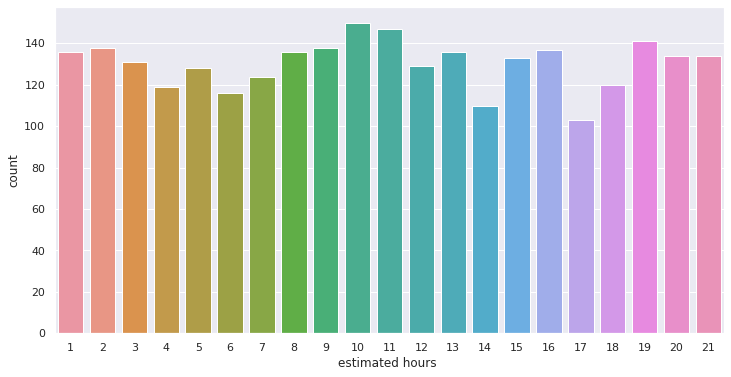

In [ ]:
# Check for data imbalance in desired value
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x=desired_column, data = data_ehm, ax=ax)
plt.show()

For the categorical values we need to change our dataset.
Instead of SupportGroupName = MMEAI, we create a new column for every support group name. A 1 will mean that the tickets belongs to that support group.

In [ ]:
data_dummy = pd.get_dummies(data_ehm['SupportGroupName'])
data_supportgroupdummy = pd.concat([data_ehm, data_dummy], axis=1, join = 'inner')
data_supportgroupdummy = data_supportgroupdummy.drop('SupportGroupName', axis=1)

## Over-sampling using SMOTE

Creating data balance in y (desired value)

Compensate imbalance via up-sampling using Synthetic Minority Oversampling Technique (SMOTE)
- Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
- Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [ ]:
# Splitting data
X = data_supportgroupdummy.loc[:, data_supportgroupdummy.columns != desired_column]
y = data_supportgroupdummy.loc[:, data_supportgroupdummy.columns == desired_column]

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Up-sampling priority
columns_X = X_train.columns
columns_y = y_train.columns

os_data_X, os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns_X)
os_data_y= pd.DataFrame(data=os_data_y, columns=columns_y)

X_train = os_data_X
y_train = os_data_y

In [ ]:
# columns_input = os_data_X.columns
# data_os = pd.concat([os_data_X, os_data_y], axis=1, join = 'inner')
# data_estimated_hours_dummy = pd.get_dummies(data_os[desired_column])
# data_final = pd.concat([data_os, data_estimated_hours_dummy], axis=1, join = 'inner')
# data_final = data_final.drop(desired_column, axis=1)

## Multiclass Classification Modelling
https://towardsdatascience.com/multi-class-classification-one-vs-all-one-vs-one-94daed32a87b#:~:text=Multi-class%20classification%20is%20the%20classification%20technique%20that%20allows,vs.%20One%202.%20Binary%20classification%20vs.%20Multi-class%20classification

https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/

https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f




In [ ]:
def predict_and_calc_MAPE(model_, X_train, y_train, X_test, y_test, title_):
  model_fit = model_.fit(X_train, y_train)
  y_pred_train = model_fit.predict(X_train)
  MAPE_train = mean_absolute_percentage_error(y_train, y_pred_train)*100

  y_pred_test = model_fit.predict(X_test)
  MAPE_test = mean_absolute_percentage_error(y_test, y_pred_test)*100

  print(f"{title_} - MAPE train:{MAPE_train:.2f}%")
  print(f"{title_} - MAPE test:{MAPE_test:.2f}%")

  return model_fit, MAPE_train, MAPE_test

In [ ]:
def show_confusion_matrix(model_fit, X_train, y_train, X_test, y_test, MAPE_train, MAPE_test, title_):
  fig, ax = plt.subplots(figsize=(15, 15))
  plot_confusion_matrix(model_fit, X_train, y_train, ax=ax, normalize = 'true') 
  plt.title(f"{title_} - MAPE train:{MAPE_train:.2f}%")
  
  fig, ax = plt.subplots(figsize=(15, 15))
  plot_confusion_matrix(model_fit, X_test, y_test, ax=ax, normalize = 'true') 
  plt.title(f"{title_} - MAPE test:{MAPE_test:.2f}%")

## Inital testing
The all of the algorithms are unable to attain a reasonable MAPE for the test set. Thus, we need to tune the algorithms.

In [ ]:
# Logistic Regression ovr
ovr = LogisticRegression(multi_class='ovr')
ovr_fit, ovr_MAPE_train, ovr_MAPE_test = predict_and_calc_MAPE(ovr, X_train, y_train, X_test, y_test, 'Logistic Regression ovr')

# Decision Tree
dtree = DecisionTreeClassifier(max_depth = 200) #, min_samples_split = 2, min_samples_leaf=10)
dtree_fit, dtree_MAPE_train, dtree_MAPE_test = predict_and_calc_MAPE(dtree, X_train, y_train, X_test, y_test, 'Decision Tree')

# SVC
svc = SVC(kernel = 'linear', C = 1)
svc_fit, svc_MAPE_train, svc_MAPE_test = predict_and_calc_MAPE(svc, X_train, y_train, X_test, y_test), 'SVC'

# KNN
knn = KNeighborsClassifier(n_neighbors = 21)
knn_fit, knn_MAPE_train, knn_MAPE_test = predict_and_calc_MAPE(knn, X_train, y_train, X_test, y_test, 'KNN')

# Naive Bayes
gnb = GaussianNB()
gnb_fit, gnb_MAPE_train, gnb_MAPE_test = predict_and_calc_MAPE(gnb, X_train, y_train, X_test, y_test, 'GNB')

# Naive Bayes - multionomial
mnb = MultinomialNB()
mnb_fit, mnb_MAPE_train, mnb_MAPE_test = predict_and_calc_MAPE(mnb, X_train, y_train, X_test, y_test, 'MNB')

MAPE train:79.01%
MAPE test:122.00%
MAPE train:25.25%
MAPE test:114.69%
MAPE train:75.01%
MAPE test:126.59%
MAPE train:109.59%
MAPE test:121.23%
MAPE train:87.95%
MAPE test:134.32%
MAPE train:75.84%
MAPE test:124.37%


In [ ]:
# Confusion Matrix
if False:
  show_confusion_matrix(ovr_fit, X_train, y_train, X_test, y_test, ovr_MAPE_train, ovr_MAPE_test, 'Logistic Regression ovr')
  show_confusion_matrix(dtree_fit, X_train, y_train, X_test, y_test, dtree_MAPE_train, dtree_MAPE_test, 'Decision Tree')
  show_confusion_matrix(svc_fit, X_train, y_train, X_test, y_test, svc_MAPE_train, svc_MAPE_test, 'SVC')
  show_confusion_matrix(knn_fit, X_train, y_train, X_test, y_test, knn_MAPE_train, knn_MAPE_test, 'KNN')
  show_confusion_matrix(gnb_fit, X_train, y_train, X_test, y_test, gnb_MAPE_train, gnb_MAPE_test, 'GNB')
  show_confusion_matrix(mnb_fit, X_train, y_train, X_test, y_test, mnb_MAPE_train, mnb_MAPE_test, 'MNB')

## Decision Tree Tuning

The test MAPE does not decrease to an acceptable level.

- **Max depth**: The ideal tree is the smallest tree possible, i.e. with fewer splits, that can accurately classify all data points.

- **Min_samples_split**: The minimum number of samples required to split an internal node.
  *	Ideal value between 1 to 40.
  *	Used to control over-fitting.
  *	Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. 
  *	Too high values can also lead to under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.

- **Min_samples_leaf**: The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
  *	Ideal value between 1 to 20.
  *	Used to control over-fitting.


In [ ]:
def optimal_depth(params, X_train, y_train, X_test, y_test):
  df = pd.DataFrame(columns=['max_depth', 'min_samples_split', 'min_samples_leaf','MAPE_train','MAPE_test'])
  best_param = list()
  best_MAPE_test = 2000

  for param in tqdm_notebook(parameters_list):
    try: 
      model = DecisionTreeClassifier(max_depth = param[0], min_samples_split = param[1], min_samples_leaf = param[2]) 
      model_fit = model.fit(X_train, y_train)
      y_pred_train = model_fit.predict(X_train)
      MAPE_train = mean_absolute_percentage_error(y_train, y_pred_train)*100

      y_pred_test = model_fit.predict(X_test)
      MAPE_test = mean_absolute_percentage_error(y_test, y_pred_test)*100

      df2 = pd.DataFrame({'max_depth':[param[0]], 
                        'min_samples_split':[param[1]], 
                        'min_samples_leaf':[param[2]],
                        'MAPE_train':[MAPE_train],
                        'MAPE_test':[MAPE_test]})
      df = df.append(df2, ignore_index=True)

      if MAPE_test < best_MAPE_test:
        best_MAPE_test = MAPE_test
        best_param = param
    except:
        continue

  return df, best_param

In [ ]:
# Optimize decision tree - Set initial values and some bounds
d = range(0, 260, 10)  # maximum depth
mss = range(2,3) # min_samples_split, to counter over-fitting
msl = range(1,2) # min_samples_leaf, to counter over-fitting

# Create a list with all possible combinations of parameters
parameters = product(d, mss, msl)
parameters_list = list(parameters)

In [ ]:
df_dtree, best_param_dtree = optimal_depth(parameters_list, X_train, y_train, X_test, y_test)

  0%|          | 0/26 [00:00<?, ?it/s]

Text(0.5, 1.0, 'MAPE of Decision Tree Classifier')

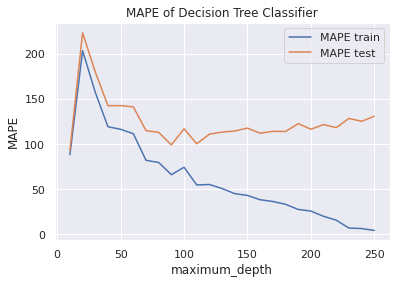

In [ ]:
plt.figure()
plt.plot(df_dtree.max_depth, df_dtree.MAPE_train, label='MAPE train')
plt.plot(df_dtree.max_depth, df_dtree.MAPE_test, label='MAPE test')
plt.legend()
plt.xlabel('maximum_depth')
plt.ylabel('MAPE')
plt.title('MAPE of Decision Tree Classifier')

## SVC tuning


In [ ]:
# Optimize SVC - Set initial values and some bounds
d = range(0, 260, 10)  # maximum depth
mss = range(2,3) # min_samples_split, to counter over-fitting
msl = range(1,2) # min_samples_leaf, to counter over-fitting

# Create a list with all possible combinations of parameters
parameters = product(d, mss, msl)
parameters_list = list(parameters)